In [2]:
import json
import os.path as p
import pandas as pd
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import os
from joblib import Parallel, delayed
import cv2

### COCO Format
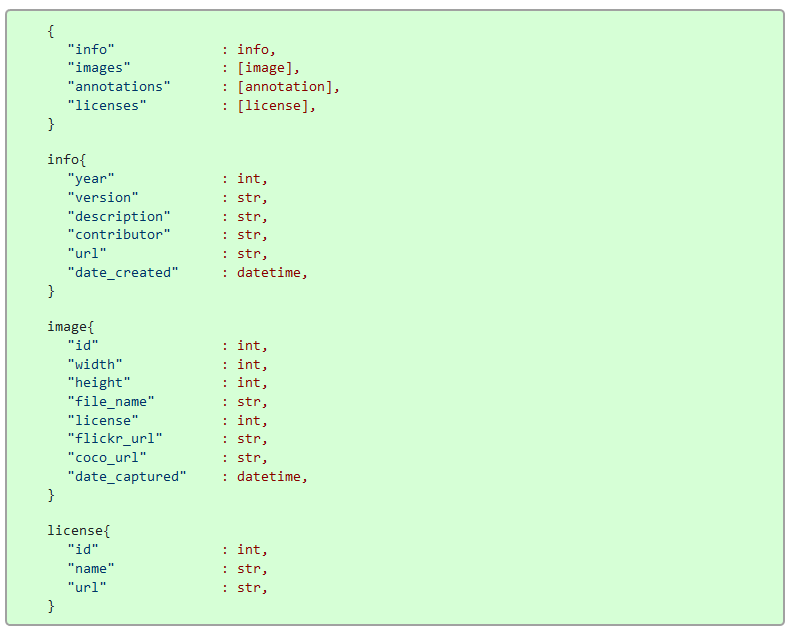

COCO Object Detection Format
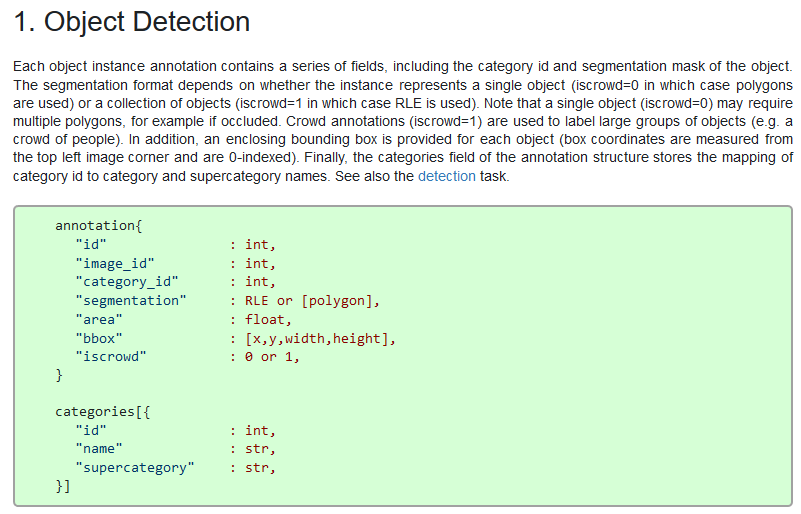

## Open Images

In [3]:
OUT_DIR = '/APL/Datasets/open-images-challenge-2019-COCO-format' 
os.makedirs(OUT_DIR, exist_ok=True)

In [4]:
OPEN_IMG = p.join('/APL/Datasets/open-images-challenge-2019')

#### Read original CSV data

In [5]:
SET = 'train'
#SET = 'validation'
#SET = 'test'

In [ ]:
# Boxes
bbox_annotation = pd.read_csv(p.join(OPEN_IMG, 'challenge-2019-' + SET + '-detection-bbox-expanded.csv'))
bbox_annotation

In [ ]:
# Define basic JSON data structure
new_data_format = {'info': {'description': 'Open Images Challenge Dataset',
  'url': 'https://storage.googleapis.com/openimages/web/index.html',
  'version': '1.0',
  'year': 2019,
  'contributor': 'Open Image authors, this format: Michael Smith @McGill University',
  'date_created': '2019/07/03'},
                  'images': [],
                  'annotations': [],
                  'categories': []}

In [ ]:
# Get all Image IDs
unique_image_ids = bbox_annotation['ImageID'].unique()
unique_image_ids

In [ ]:
# Create image str ID to int ID mapping
im_id_mapping = []
i = 0

for im in tqdm(unique_image_ids):
    im_id_mapping.append((im,i))
    i += 1

In [ ]:
im_id_mapping

In [ ]:
# Write mapping for image ID (string) to int to disk
df = pd.DataFrame(data=im_id_mapping, columns=['ImageID','IntIndex'])
df.to_csv(os.path.join(OPEN_IMG, 'challenge-2019-' + SET + '-image-ID-mapping.csv'), index=False)

In [ ]:
# Get all image sizes
results = []
for originalID,newID in tqdm(im_id_mapping):
    im_filename = originalID + '.jpg'
    
    with Image.open(p.join(OPEN_IMG, SET, im_filename)) as image:
        im_size = image.size 
    
    results.append({'file_name': im_filename,
     'height': im_size[1],
     'width': im_size[0],
     'id': newID})

In [ ]:
# Make sure above is done
print(len(results))
print(len(im_id_mapping))

In [ ]:
# List of images is done -> save
new_data_format['images'] = results

## Class mapping stuff 

In [ ]:
#Get category names
category_csv = pd.read_csv(os.path.join(OPEN_IMG,'challenge-2019-classes-description-500.csv'),header=None,names=['MID','Description'])
category_csv

In [ ]:
# Get label hierarchy (not used)
with open(os.path.join(OPEN_IMG, 'challenge-2019-label500-hierarchy.json')) as f:
    label_hierarchy = json.load(f)
label_hierarchy

In [ ]:
# Create mapping from name to MID
category_list = []
category_MID_mapping = []
i = 0
for row in category_csv.itertuples():
    # Supercategory = None because we already processed everything using the OID script
    category_list.append({'id': i, 'name': row.Description, 'supercategory': None})
    # Save mapping from original name to new ID
    category_MID_mapping.append((row.MID, i))
    i += 1

In [ ]:
# Save mapping to disk
MID_mapping_df = pd.DataFrame(data=category_MID_mapping, columns=['MID','IntIndex'])
MID_mapping_df.to_csv(os.path.join(OPEN_IMG, 'challenge-2019-category-ID-mapping.csv'), index=False)

In [ ]:
# Save category data
new_data_format['categories'] = category_list

In [ ]:
category_MID_mapping_dict = {}
for i in category_MID_mapping:
    category_MID_mapping_dict[i[0]] = i[1]

## End category stuff

In [ ]:
# Create dictinary mapping from Open Images string ID to image info
im_info_map = {p.splitext(i['file_name'])[0]:i for i in new_data_format['images']}    
im_info_map

In [ ]:
for r in bbox_annotation.itertuples():
    print(r)
    break

In [ ]:
# load line profiler
%load_ext line_profiler

In [ ]:
%lprun  -f create_annotations create_annotations(bbox_annotation,im_info_map,MID_mapping_df)

In [ ]:
# Create annotations
# def create_annotations(bbox_annotation,im_info_map,MID_mapping_df):
def create_annotations():
#     iter_count = 0
    list_annot = []
    for r in tqdm(bbox_annotation.itertuples(), total=len(bbox_annotation)):
        im_info = im_info_map[r.ImageID]
        im_w = im_info['width']
        im_h = im_info['height']

        x = r.XMin * im_w
        w = (r.XMax - r.XMin) * im_w
        y = r.YMin * im_h
        h = (r.YMax - r.YMin) * im_h

        #Get real category name (iloc = 0 is first match)
        category_real_name = category_MID_mapping_dict[r.LabelName]

        list_annot.append({'id': r.Index,
                     'image_id': im_info['id'],
                     'category_id': category_real_name,
                     'bbox': [x, y, w, h],
                     'segmentation': [[x, y, x, y + h, x + w, y + h, x + w, y]],
                     'area': w * h,
                     'iscrowd': 0}) # Set to 0 because otherwise it gets ignored
#         iter_count += 1
#         if iter_count == 5000:
#             return list_annot
    return list_annot

In [ ]:
list_annot = create_annotations()

In [ ]:
new_data_format['annotations'] = list_annot

In [ ]:
new_data_format

In [ ]:
OUTPUT_JSON = p.join(OUT_DIR, SET + '.json')

In [ ]:
#Output to file
with open(OUTPUT_JSON, 'w') as f:
    json.dump(new_data_format,f)

In [12]:
## Fix for is group of
JSON_FILE_FIX='/APL/Datasets/open-images-challenge-2019-COCO-format/validation.json'
with open(JSON_FILE_FIX) as f:
    dt = json.load(f)

annotations = dt['annotations']

In [13]:
new_annot = []
for i in tqdm(annotations):
    if 'iscrowd' in i:
        i['iscrowd'] = 0
    new_annot.append(i)

In [14]:
dt['annotations'] = new_annot
with open(JSON_FILE_FIX, 'w') as f:
    json.dump(dt,f)